In [432]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### The Data

[Based off this probability lab from Coursera's Stats With R course](https://github.com/StatsWithR/labs/blob/master/1.3_probability/probability.Rmd)

In [433]:
data = pd.read_csv("kobe_basket.csv")
data.head(5)

,Unnamed: 0,vs,game,quarter,time,description,shot
0,1,ORL,1,1,9:47,Kobe Bryant makes 4-foot two point shot,H
1,2,ORL,1,1,9:07,Kobe Bryant misses jumper,M
2,3,ORL,1,1,8:11,Kobe Bryant misses 7-foot jumper,M
3,4,ORL,1,1,7:41,Kobe Bryant makes 16-foot jumper (Derek Fisher...,H
4,5,ORL,1,1,7:03,Kobe Bryant makes driving layup,H


Kobe's shots per game in the LAL v. Orlando 2009 playoff series:

In [434]:
shots_game= pd.DataFrame(data.game.value_counts().sort_index())
shots_game.columns = ["shots_per_game"]
shots_game.T

,1,2,3,4,5
shots_per_game,34,21,25,30,23


We have 133 shots worth of data to evaluate, with 75 shots missed and 58 shots made.

In [368]:
pd.DataFrame(data.shot.value_counts()).T

,M,H
shot,75,58


In [367]:
data.shape

(133, 7)

On average, Kobe's average shots made for this series is:

In [435]:
shots_made_avg = 58/133
shots_made_avg

0.43609022556390975

### Finding Streaks

In [436]:
def calc_streak(data):
    
    streak = []
    count = 0
    
    for shot in data:
        
        if shot == "H":
            count +=1
            
        elif shot == "M":
            streak.append(count)
            count = 0
            
    return streak

#### Kobe's shot streaks throughout the series

In [437]:
kobe_streak = calc_streak(data['shot'])

In [441]:
kobe_streak = pd.DataFrame(kobe_streak, columns=["streaks"])

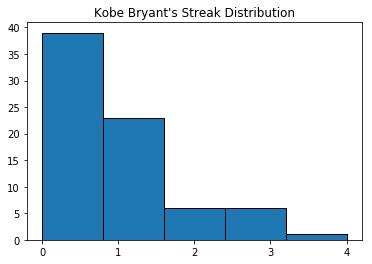

In [442]:
plt.hist(kobe_streak.streaks, bins=5, edgecolor='black', linewidth=1)
plt.xticks(range(0,5))
plt.title("Kobe Bryant's Streak Distribution")
plt.show()

In [349]:
kobe_streak_summary = pd.DataFrame(kobe_streak.streaks.value_counts().sort_index()).T
kobe_streak_summary

,0,1,2,3,4
streaks,39,23,6,6,1


In this series, Kobe had six streaks were he made 2 shots in a row, six streaks where he made 3 shots in a row, and one streak of 4 shots in a row.

#### Simulating a random player's streak

Using the same probability of making a shot as Kobe's shots made average for this series:

In [374]:
n = 1
p = shots_made_avg
player_1 = np.random.binomial(n,p,133)

In [375]:
player_1 = list(player_1)
for j in range(len(player_1)):
    if player_1[j] == 1:
        player_1[j] ="H"
    else:
        player_1[j] = "M"

In [376]:
player_1_streak = calc_streak(player_1)
player_1_streak = pd.DataFrame(player_1_streak, columns=["streaks"])


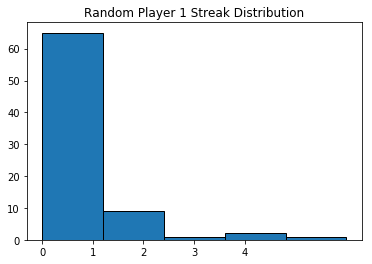

In [377]:
plt.hist(player_1_streak.streaks, bins=5, edgecolor='black', linewidth=1)
plt.xticks(range(0,5))
plt.title("Random Player 1 Streak Distribution")
plt.show()

In [378]:
pd.DataFrame(player_1_streak.streaks.value_counts().sort_index()).T

,0,1,2,3,4,6
streaks,46,19,9,1,2,1


#### Simulating 10,000 random players' streaks

Using the same probability of making a shot as Kobe's shots made average for this series:

In [388]:
sims = []

for player in range(10000):
    n = 1
    p = shots_made_avg
   
    player_shots = np.random.binomial(n,p,133)
    player_shots = list(player_shots)
    
    for j in range(len(player_shots)):
        if player_shots[j] == 1:
            player_shots[j] ="H"
        else:
            player_shots[j] = "M"
    
    player_streak = calc_streak(player_shots)
    player_streak = pd.DataFrame(player_streak, columns=["streaks"])
    sims.append(dict(player_streak.streaks.value_counts().sort_index()))


In [389]:
sims_df = pd.DataFrame(sims).fillna(0)

In [390]:
sims_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,31,17,7.0,6.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,48,21,3.0,4.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,40,19,11.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,48,21,6.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,41,14,7.0,6.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [444]:
sims_df.agg(['min', 'max', 'mean', 'std']).round(decimals=2)
 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
min,19.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,74.00,33.00,20.00,11.00,8.00,5.00,4.00,3.00,2.00,2.00,2.00,1.00,1.00,1.00,1.00,1.00
mean,42.49,18.47,7.94,3.45,1.49,0.64,0.29,0.12,0.05,0.02,0.01,0.00,0.00,0.00,0.00,0.00
std,7.06,3.78,2.50,1.72,1.17,0.78,0.53,0.35,0.23,0.15,0.09,0.06,0.04,0.03,0.02,0.01


In [391]:
kobe_streak_summary

,0,1,2,3,4
streaks,39,23,6,6,1


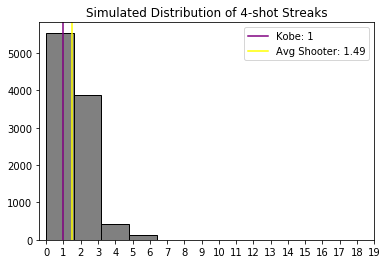

In [447]:
sims_df[4].hist(bins=5, edgecolor='black', linewidth=1, color='grey')
plt.xticks(range(0,20))
plt.grid()
plt.axvline(x=kobe_streak_summary[4]['streaks'], color='purple', label='Kobe: '+str(kobe_streak_summary[4]['streaks']))
plt.axvline(x=np.mean(sims_df[4]), color='yellow', label='Avg Shooter: '+str(round(np.mean(sims_df[4]),2)))
plt.title('Simulated Distribution of 4-shot Streaks')
plt.legend()
plt.show()

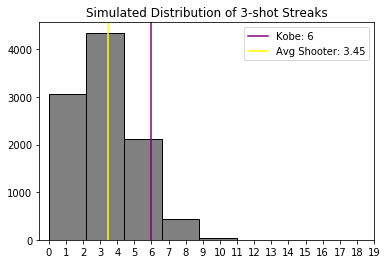

In [446]:
sims_df[3].hist(bins=5, edgecolor='black', linewidth=1, color='grey')
plt.xticks(range(0,20))
plt.grid()
plt.axvline(x=kobe_streak_summary[3]['streaks'], color='purple', label='Kobe: '+str(kobe_streak_summary[3]['streaks']))
plt.axvline(x=np.mean(sims_df[3]), color='yellow', label='Avg Shooter: '+str(round(np.mean(sims_df[3]), 2)))
plt.legend()
plt.title('Simulated Distribution of 3-shot Streaks')
plt.show()

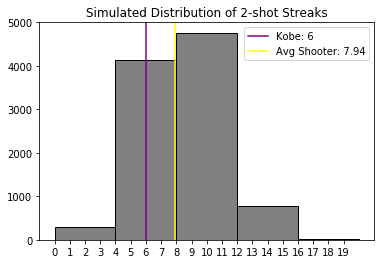

In [445]:
sims_df[2].hist(bins=5, edgecolor='black', linewidth=1, color='grey')
plt.xticks(range(0,20))
plt.grid()
plt.axvline(x=kobe_streak_summary[2]['streaks'], color='purple', label='Kobe: '+str(kobe_streak_summary[2]['streaks']))
plt.axvline(x=np.mean(sims_df[2]), color='yellow', label='Avg Shooter: '+str(round(np.mean(sims_df[2]), 2)))
plt.legend()
plt.title('Simulated Distribution of 2-shot Streaks')
plt.show()